## Part 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

### Load Datasets

In [2]:
# Step 1: Load the datasets
loaded_data = np.load('svhn_datasets.npz')
X_train, y_train = loaded_data['X_train'], loaded_data['y_train']
X_val, y_val = loaded_data['X_val'], loaded_data['y_val']
X_test, y_test = loaded_data['X_test'], loaded_data['y_test']

In [3]:
# Check size of datasets
print("Training data size: ", X_train.shape)
print("Validation data size: ", X_val.shape)
print("Testing data size: ", X_test.shape)

Training data size:  (51279, 32, 32, 3)
Validation data size:  (14725, 32, 32, 3)
Testing data size:  (7253, 32, 32, 3)


In [4]:
# Flatten the images
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Now check the size of datasets
print("Training data size: ", X_train.shape)
print("Validation data size: ", X_val.shape)
print("Testing data size: ", X_test.shape)

Training data size:  (51279, 3072)
Validation data size:  (14725, 3072)
Testing data size:  (7253, 3072)


In [5]:
# Check for missing values
print("Missing values in training data: ", np.isnan(X_train).any())
print("Missing values in validation data: ", np.isnan(X_val).any())
print("Missing values in testing data: ", np.isnan(X_test).any())

Missing values in training data:  False
Missing values in validation data:  False
Missing values in testing data:  False


In [6]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### 1. Constructing Neural Network
- 2 layer neural net with hidden layer size 128 x 64

In [10]:
# Step 1: Create a MLPClassifier with 2 layers
mlp_classifier_org = MLPClassifier(hidden_layer_sizes=(128, 64), random_state=42, early_stopping=True, max_iter=100)

In [ ]:
# Train the model
mlp_classifier_org.fit(X_train, y_train)

# Predict the validation data
y_pred = mlp_classifier_org.predict(X_val)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)

# Print the accuracy
print("Validation Accuracy of the model: ", accuracy)

Validation Accuracy of the model:  0.8133106960950764


In [ ]:
# Predict on the test data
y_pred = mlp_classifier_org.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Test Accuracy of the model: ", accuracy)

Test Accuracy of the model:  0.8078036674479526


### 2. Hyperparameter Tuning

In [11]:
# Step 2. Use Grid-Search to find optimal hyperparameters

# Define the parameter grid
param_grid = {
    'batch_size': [32, 64, 128],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

In [12]:
# Perform GridSearchCV with 3-fold cross validation
grid_search = GridSearchCV(mlp_classifier_org, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=MLPClassifier(early_stopping=True,
                                     hidden_layer_sizes=(128, 64), max_iter=100,
                                     random_state=42),
             n_jobs=-1,
             param_grid={'batch_size': [32, 64, 128],
                         'learning_rate_init': [0.001, 0.01, 0.1]},
             verbose=2)

In [14]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print(best_params)

# Get best accuracy
best_accuracy = grid_search.best_score_
print(best_accuracy)

{'batch_size': 128, 'learning_rate_init': 0.001}
0.7955498352151954


### 3. Various Activation Functions

In [32]:
# General function to train the model and store validation and training loss

def training_model(model, X_train, y_train, X_val, y_val, epochs, early_stopping=True):
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.partial_fit(X_train, y_train, classes=np.unique(y_train))
        
        # Calculate the training loss
        train_loss = model.loss_
        training_loss.append(train_loss)

        # Calculate the validation loss
        val_loss = log_loss(y_val, model.predict_proba(X_val))
        validation_loss.append(val_loss)

        print(f"Epoch: {epoch+1} | Training Loss: {train_loss} | Validation Loss: {val_loss}")

        if early_stopping:
            if epoch > 10:
                if validation_loss[-1] > np.mean(validation_loss[-5:]):
                    print(f"Early stopping at epoch: {epoch+1}")
                    break
                else:
                    if np.mean(validation_loss[-5:]) - validation_loss[-1] < 1e-4 :
                        print(f"Early stopping at epoch: {epoch+1}")
                        break

    return training_loss, validation_loss, model

Epoch: 1 | Training Loss: 1.4770082248976522 | Validation Loss: 1.0523789874967144
Epoch: 2 | Training Loss: 0.984047500424945 | Validation Loss: 0.9561627804315121
Epoch: 3 | Training Loss: 0.8521252830804884 | Validation Loss: 0.8687348492546433
Epoch: 4 | Training Loss: 0.759199036650787 | Validation Loss: 0.8234060546502503
Epoch: 5 | Training Loss: 0.7038939972311424 | Validation Loss: 0.7995844585696652
Epoch: 6 | Training Loss: 0.6645137855082336 | Validation Loss: 0.8018621257080483
Epoch: 7 | Training Loss: 0.6295909286212464 | Validation Loss: 0.7574962635112681
Epoch: 8 | Training Loss: 0.6025829168089765 | Validation Loss: 0.7661396204516193
Epoch: 9 | Training Loss: 0.5675358704515039 | Validation Loss: 0.7526550356642816
Epoch: 10 | Training Loss: 0.5587222022350586 | Validation Loss: 0.7370705095757543
Epoch: 11 | Training Loss: 0.5354909892744053 | Validation Loss: 0.7154520635750273
Epoch: 12 | Training Loss: 0.5197537562794063 | Validation Loss: 0.7507282059151178
Ear

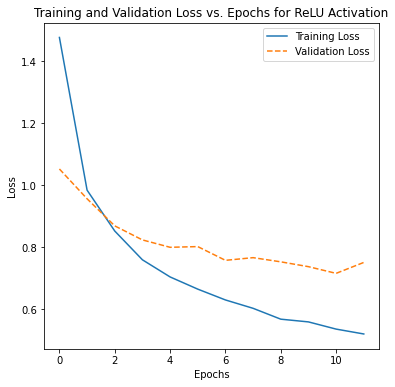

In [34]:
# 1. ReLU
mlp_relu = MLPClassifier(hidden_layer_sizes=(128, 64), 
                         random_state=42, 
                         batch_size = 128, 
                         learning_rate_init = 0.001, 
                         activation="relu", 
                         max_iter=100)

# Train the model
training_loss_relu, validation_loss_relu, mlp_relu = training_model(mlp_relu, X_train, y_train, X_val, y_val, 100)

# Plot the curves
plt.figure(figsize=(6, 6))

plt.plot(training_loss_relu, label=f'Training Loss')
plt.plot(validation_loss_relu, label=f'Validation Loss', linestyle='dashed')

plt.title('Training and Validation Loss vs. Epochs for ReLU Activation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch: 1 | Training Loss: 2.1535376922300227 | Validation Loss: 1.9478054357333123
Epoch: 2 | Training Loss: 1.6874370297556665 | Validation Loss: 1.5088386012673352
Epoch: 3 | Training Loss: 1.3774156691170236 | Validation Loss: 1.3093028097891863
Epoch: 4 | Training Loss: 1.2282779849521346 | Validation Loss: 1.19405537185821
Epoch: 5 | Training Loss: 1.1208694996381632 | Validation Loss: 1.1060633530688369
Epoch: 6 | Training Loss: 1.034906755573623 | Validation Loss: 1.038339915713879
Epoch: 7 | Training Loss: 0.9670614157018451 | Validation Loss: 0.9901290882383462
Epoch: 8 | Training Loss: 0.9174240929496089 | Validation Loss: 0.9419275563459808
Epoch: 9 | Training Loss: 0.8716257263550193 | Validation Loss: 0.903730425537506
Epoch: 10 | Training Loss: 0.8352597518060695 | Validation Loss: 0.8839201110361934
Epoch: 11 | Training Loss: 0.806434407600236 | Validation Loss: 0.8792229799297088
Epoch: 12 | Training Loss: 0.7878866719412282 | Validation Loss: 0.8576525620563109
Epoch: 

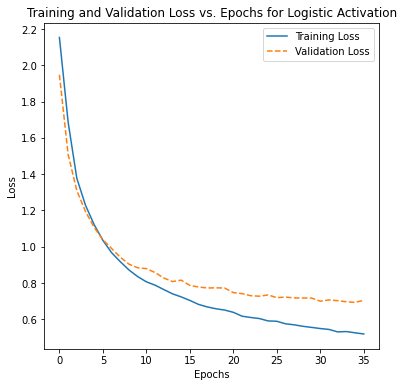

In [35]:
# 2. Logistic
mlp_logistic = MLPClassifier(hidden_layer_sizes=(128, 64), 
                             random_state=42, 
                             batch_size = 128, 
                             learning_rate_init = 0.001, 
                             activation="logistic",  
                             max_iter=100)

# Train the model
training_loss_logistic, validation_loss_logistic ,mlp_logistic = training_model(mlp_logistic, X_train, y_train, X_val, y_val, 100)

# Plot the curves
plt.figure(figsize=(6, 6))

plt.plot(training_loss_logistic, label=f'Training Loss')
plt.plot(validation_loss_logistic, label=f'Validation Loss', linestyle='dashed')

plt.title('Training and Validation Loss vs. Epochs for Logistic Activation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch: 1 | Training Loss: 2.2393078881569735 | Validation Loss: 2.1343158986916424
Epoch: 2 | Training Loss: 2.015753839394791 | Validation Loss: 1.859986318174188
Epoch: 3 | Training Loss: 1.6997373388789108 | Validation Loss: 1.575538327797063
Epoch: 4 | Training Loss: 1.4338758336304755 | Validation Loss: 1.3594895940561353
Epoch: 5 | Training Loss: 1.252087101378218 | Validation Loss: 1.2150321668295554
Epoch: 6 | Training Loss: 1.1497545807453065 | Validation Loss: 1.1628586915286516
Epoch: 7 | Training Loss: 1.0763346314727356 | Validation Loss: 1.1426216045750421
Epoch: 8 | Training Loss: 1.0343037997108313 | Validation Loss: 1.0604469644183294
Epoch: 9 | Training Loss: 0.9911433275932943 | Validation Loss: 1.023183379760096
Epoch: 10 | Training Loss: 0.9615512905200003 | Validation Loss: 0.9891566784838017
Epoch: 11 | Training Loss: 0.9331319202004398 | Validation Loss: 0.9874402177112196
Epoch: 12 | Training Loss: 0.9197373765611415 | Validation Loss: 0.9963988330438407
Epoch:

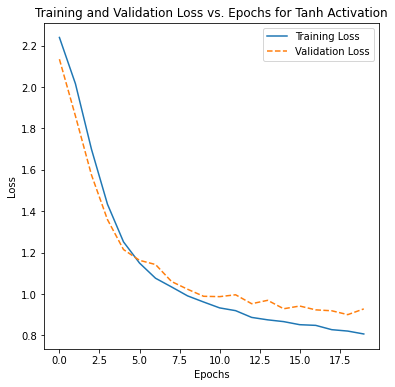

In [36]:
# 3. Tanh
mlp_tanh = MLPClassifier(hidden_layer_sizes=(128, 64), 
                         random_state=42, 
                         batch_size = 128, 
                         learning_rate_init = 0.001, 
                         activation="tanh", 
                         max_iter=100)

# Train the model
training_loss_tanh, validation_loss_tanh ,mlp_tanh = training_model(mlp_tanh, X_train, y_train, X_val, y_val, 100)

# Plot the curves
plt.figure(figsize=(6, 6))

plt.plot(training_loss_tanh, label=f'Training Loss')
plt.plot(validation_loss_tanh, label=f'Validation Loss', linestyle='dashed')

plt.title('Training and Validation Loss vs. Epochs for Tanh Activation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch: 1 | Training Loss: 2.616063816149662 | Validation Loss: 2.2112025227628758
Epoch: 2 | Training Loss: 2.189427239312036 | Validation Loss: 2.1692930443809506
Epoch: 3 | Training Loss: 2.1762242033887773 | Validation Loss: 2.171255780197174
Epoch: 4 | Training Loss: 2.1751142426057233 | Validation Loss: 2.1718204505336662
Epoch: 5 | Training Loss: 2.1748002901526076 | Validation Loss: 2.205113463787723
Epoch: 6 | Training Loss: 2.173655623718843 | Validation Loss: 2.2072134535490693
Epoch: 7 | Training Loss: 2.172898385960333 | Validation Loss: 2.222148964152671
Epoch: 8 | Training Loss: 2.1710776544227968 | Validation Loss: 2.2062098722986887
Epoch: 9 | Training Loss: 2.1700924041989804 | Validation Loss: 2.203187545456912
Epoch: 10 | Training Loss: 2.16793876272366 | Validation Loss: 2.2069442354110693
Epoch: 11 | Training Loss: 2.164898536802495 | Validation Loss: 2.2071249760814355
Epoch: 12 | Training Loss: 2.162804414274756 | Validation Loss: 2.1936240852660127
Epoch: 13 | T

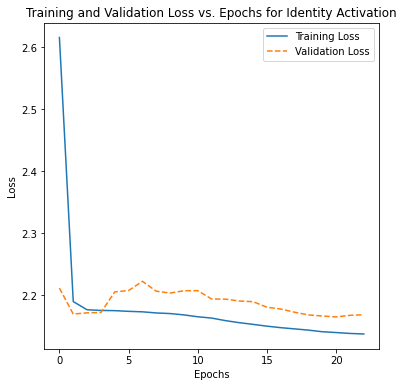

In [37]:
# 4. Identity
mlp_identity = MLPClassifier(hidden_layer_sizes=(128, 64), 
                             random_state = 42, 
                             batch_size = 128, 
                             learning_rate_init = 0.001, 
                             activation="identity", 
                             max_iter=100)

# Train the model
training_loss_identity, validation_loss_identity ,mlp_identity = training_model(mlp_identity, X_train, y_train, X_val, y_val, 100)

# Plot the curves
plt.figure(figsize=(6, 6))

plt.plot(training_loss_identity, label=f'Training Loss')
plt.plot(validation_loss_identity, label=f'Validation Loss', linestyle='dashed')

plt.title('Training and Validation Loss vs. Epochs for Identity Activation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 4. Predictions on Test Set

In [27]:
# Save the models
import pickle

# Save the model with ReLU activation
filename_one = 'mlp_relu.sav'
pickle.dump(mlp_relu, open(filename_one, 'wb'))

# Save the model with Logistic activation
filename_two = 'mlp_logistic.sav'
pickle.dump(mlp_logistic, open(filename_two, 'wb'))

# Save the model with Tanh activation
filename_three = 'mlp_tanh.sav'
pickle.dump(mlp_tanh, open(filename_three, 'wb'))

# Save the model with Identity activation
filename_four = 'mlp_identity.sav'
pickle.dump(mlp_identity, open(filename_four, 'wb'))

In [38]:
# Load the models
mlp_relu_new = pickle.load(open('mlp_relu.sav', 'rb'))
mlp_logistic_new = pickle.load(open('mlp_logistic.sav', 'rb'))
mlp_tanh_new = pickle.load(open('mlp_tanh.sav', 'rb'))
mlp_identity_new = pickle.load(open('mlp_identity.sav', 'rb'))

# Predict on the test data
# y_pred_relu = mlp_relu_new.predict(X_test)
# y_pred_logistic = mlp_logistic_new.predict(X_test)
# y_pred_tanh = mlp_tanh_new.predict(X_test)
# y_pred_identity = mlp_identity_new.predict(X_test)

y_pred_relu = mlp_relu.predict(X_test)
y_pred_logistic = mlp_logistic.predict(X_test)
y_pred_tanh = mlp_tanh.predict(X_test)
y_pred_identity = mlp_identity.predict(X_test)


# Calculate the accuracy
accuracy_relu = accuracy_score(y_test, y_pred_relu)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_tanh = accuracy_score(y_test, y_pred_tanh)
accuracy_identity = accuracy_score(y_test, y_pred_identity)

# Print the accuracy
print("Test Accuracy of the model with ReLU activation: ", accuracy_relu)
print("Test Accuracy of the model with Logistic activation: ", accuracy_logistic)
print("Test Accuracy of the model with Tanh activation: ", accuracy_tanh)
print("Test Accuracy of the model with Identity activation: ", accuracy_identity)

Test Accuracy of the model with ReLU activation:  0.7865710740383289
Test Accuracy of the model with Logistic activation:  0.7762305252998759
Test Accuracy of the model with Tanh activation:  0.7067420377774714
Test Accuracy of the model with Identity activation:  0.2523093892182545


### Part 3

In [41]:
best_model = mlp_relu

from sklearn.metrics import confusion_matrix

# Predictions on the test set
y_pred_best = best_model.predict(X_test)

# Find misclassified indices
misclassified_indices = np.where(y_pred_best != y_test)[0]

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


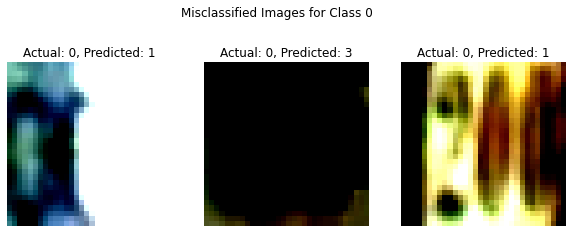

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


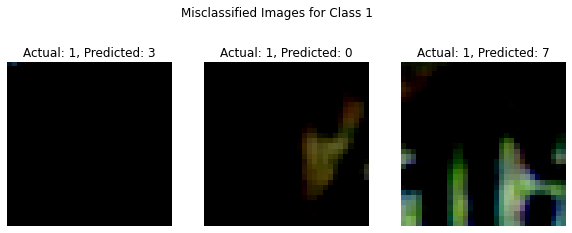

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


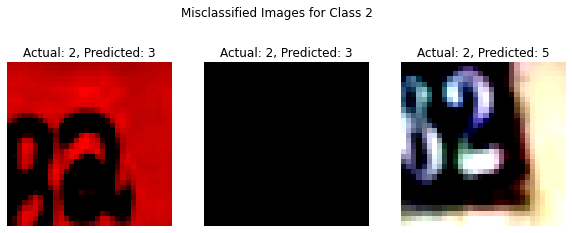

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


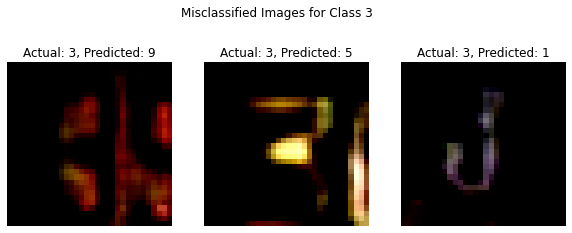

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


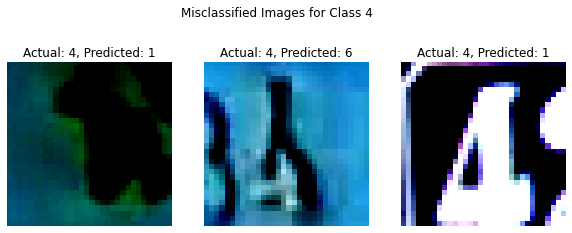

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


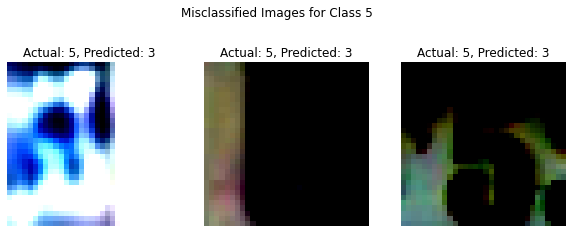

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


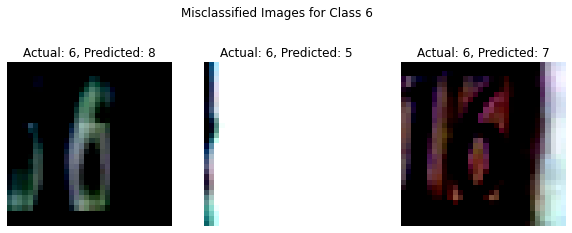

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


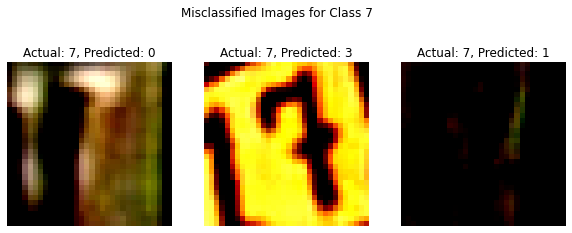

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


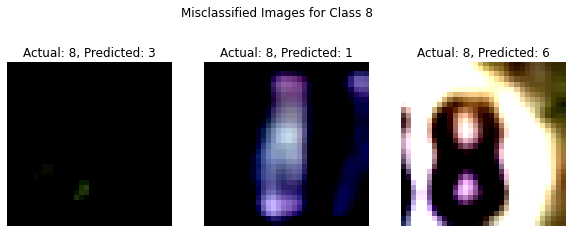

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


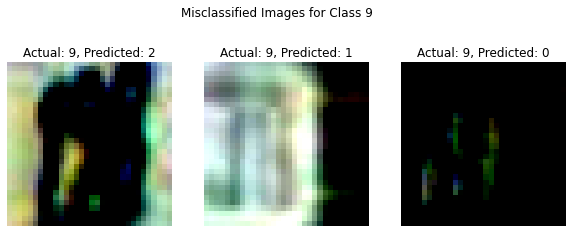

In [43]:
# 1. Visualize 3 misclassified images for each class
for class_label in range(10):
    class_indices = np.where(y_test == class_label)[0]
    misclassified_class_indices = np.intersect1d(class_indices, misclassified_indices)[:3]

    plt.figure(figsize=(10, 4))
    for i, index in enumerate(misclassified_class_indices):
        plt.subplot(1, 3, i + 1)
        plt.imshow(X_test[index].reshape(32, 32, 3))
        plt.title(f'Actual: {y_test[index]}, Predicted: {y_pred_best[index]}')
        plt.axis('off')
    plt.suptitle(f'Misclassified Images for Class {class_label}')
    plt.show()

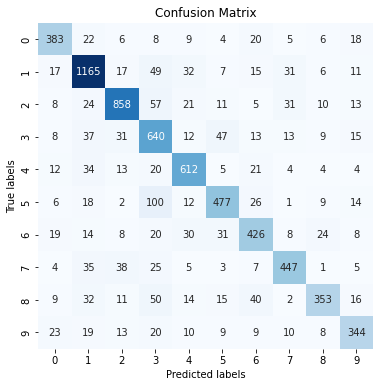

In [44]:
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()